In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]= (10,2)
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.impute import KNNImputer


In [3]:
def sliderPlot(df1,t=None):
    if t =="line":
        fig = px.line(x=df1.index, y=df1)
    else:
        fig = px.scatter(x=df1.index, y=df1)
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=2, label="2y", step="year", stepmode="backward"),
                dict(count=3, label="3y", step="year", stepmode="backward"),
                dict(step="all")
            ])))
    fig.show()
    return
def scatter(df1):
    plt.scatter(df1.index, df1, color='k',s=10)
    plt.xlabel('timestamp')
    # plt.title('current')
    plt.show()

def create_features(hourly_data):
    hourly_data = hourly_data.copy()
    # Check if the index is in datetime format
    if not isinstance(hourly_data.index, pd.DatetimeIndex):
        hourly_data.index = pd.to_datetime(hourly_data.index)
    
    hourly_data['sec'] = hourly_data.index.second
    hourly_data['minute'] = hourly_data.index.minute
    hourly_data['hour'] = hourly_data.index.hour
    hourly_data['day'] = hourly_data.index.day
    hourly_data['dayofweek'] = hourly_data.index.dayofweek
    hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
    hourly_data['month'] = hourly_data.index.month
    hourly_data['quarter'] = hourly_data.index.quarter

    return hourly_data

In [4]:
""" data ingestion """

# lst = ['wm',"ac1","f",'tv']
lst = ['ac']
path = "d:/NILM/Data_files/Parquet/Appliances12_06_04_08/"

""" data ingestion done """

""" data validation and transformation """
complete_data_lst = []
date_dit ={}
for i in range(len(lst)):
    counter = 0
    dit = {}
    df = pd.read_parquet(f"{path}{lst[i]}.parquet")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.drop_duplicates(inplace=True)
    df.set_index(['timestamp'],inplace=True ,drop=True)  
    df.drop(df[(df['frequency']>51) | (df['frequency']<49)].index, inplace=True)
    df.drop(df[(df['PF']>1) | (df['PF']<0)].index, inplace=True)
    # df.drop(df[(df['current']>20) |(df['current']<0.07)].index, inplace=True)
    df.drop(df[df['voltage']<140].index, inplace=True)
    
    """ data validation done """
    
    """ data transformation """
    df['power'] = (df['voltage'] * df['current'] * df['PF']).round(2)
    if lst[i]=="f":
        df_appliance = df[['power',"voltage",'current']].resample(rule="1s").asfreq()
        df_appliance = df_appliance.rename(columns={'power': f'{lst[i]}_A', 'voltage': f'{lst[i]}_V', 'current': f'{lst[i]}_C'})
        unique_dates = pd.Series(df.index.date).unique()
        for date1 in unique_dates:
            hours_lst = []
            df_date = df[df.index.to_series().dt.date == date1]
            hours = df_date.index.hour.unique()
            for y in hours:
                hours_lst.append(y)
                counter+=1
            dit[f"{date1}"] = hours_lst
    else:
        df_sample_lst = []
        unique_dates = pd.Series(df.index.date).unique()
        for date1 in unique_dates:
            hours_lst = []
            df_date = df[df.index.to_series().dt.date == date1]
            hours = df_date.index.hour.unique()
            for y in hours:
                if hours.empty:
                    continue
                hours_lst.append(y)
                date2 = f"{date1} {y:02d}"
                df_hour = df_date.loc[date2]
                counter+=1
                mins = df_hour.index.minute.unique()
                if mins.empty:
                    continue
                for m in mins:
                    date3 = f"{date2}{m:02d}"
                    df_min = df_hour.loc[date3]
                    df_resampled_hour = df_min[['power',"voltage",'current']].resample(rule="1s").asfreq()
                    df_sample_lst.append(df_resampled_hour) # adding each hour data in lst


        df_appliance = pd.concat(df_sample_lst)
        df_appliance = df_appliance.rename(columns={'power': f'{lst[i]}_A', 'voltage': f'{lst[i]}_V', 'current': f'{lst[i]}_C'})

    date_dit[f"{lst[i]}"] = dit
    print(f"days when {lst[i]} is active :", len(unique_dates))
    print("no. of hours:", counter)
    complete_data_lst.append(df_appliance)


days when ac is active : 50
no. of hours: 148


In [9]:
df1 = complete_data_lst[0]
print(len(df1), df1['ac_A'].isna().sum())
df1

341412 3680


ac_A    ac_V   ac_C
timestamp                                  
2013-06-12 15:37:44  1695.42  206.51  8.318
2013-06-12 15:37:45  1693.94  206.49  8.320
2013-06-12 15:37:46  1692.68  206.57  8.319
2013-06-12 15:37:47  1693.01  206.50  8.315
2013-06-12 15:37:48  1693.09  206.56  8.313
...                      ...     ...    ...
2013-08-03 17:32:16  1695.33  203.78  8.429
2013-08-03 17:32:17  1698.77  203.82  8.453
2013-08-03 17:32:18  1697.96  203.83  8.440
2013-08-03 17:32:19  1698.43  203.91  8.439
2013-08-03 17:32:20  1698.07  203.65  8.448

[341412 rows x 3 columns]

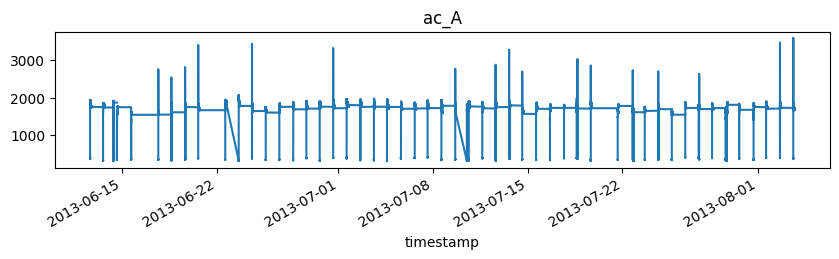

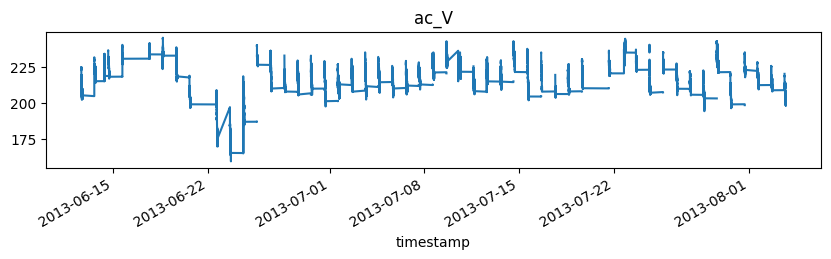

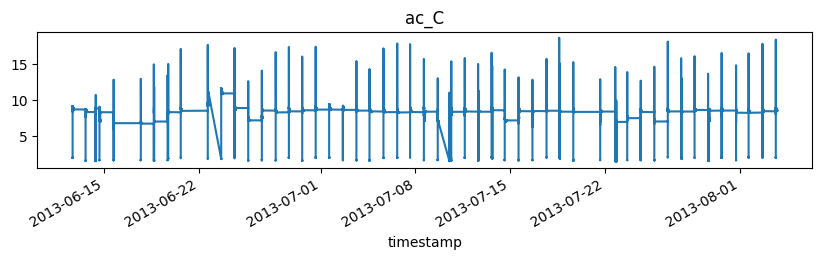

In [19]:
for i in [0,1,2]:
    df1[df1.columns[i]].plot()
    plt.title(df1.columns[i])
    plt.show()

In [16]:
df1.loc['2013-06-17']

ac_A    ac_V   ac_C
timestamp                                  
2013-06-17 16:38:15  1543.52  230.78  6.749
2013-06-17 16:38:16  1542.91  230.69  6.749
2013-06-17 16:38:17  1542.82  230.71  6.748
2013-06-17 16:38:18  1543.73  230.71  6.752
2013-06-17 16:38:19      NaN     NaN    NaN
...                      ...     ...    ...
2013-06-17 17:22:55  1551.50  233.60  6.702
2013-06-17 17:22:56  1549.08  233.69  6.689
2013-06-17 17:22:57  1549.05  233.65  6.690
2013-06-17 17:22:58  1548.65  233.66  6.688
2013-06-17 17:22:59  1547.96  233.73  6.683

[2682 rows x 3 columns]

In [35]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
df = df1.copy()
for column in df.columns:
    # Replace missing values with NaNs in the current column
    missing_indices = df[column].index[df[column].isna()]
    non_missing_indices = df[column].index[df[column].notna()]
    # Convert timestamps to numerical values
    non_missing_indices_numeric = non_missing_indices.to_numpy()
    missing_indices_numeric = missing_indices.to_numpy()
    # Create a cubic spline interpolation function for the current column
    cs = CubicSpline(non_missing_indices_numeric, df[column].dropna().to_numpy(), bc_type='natural')
    # Interpolate missing values in the current column
    df.loc[missing_indices, column] = cs(missing_indices_numeric)
# df


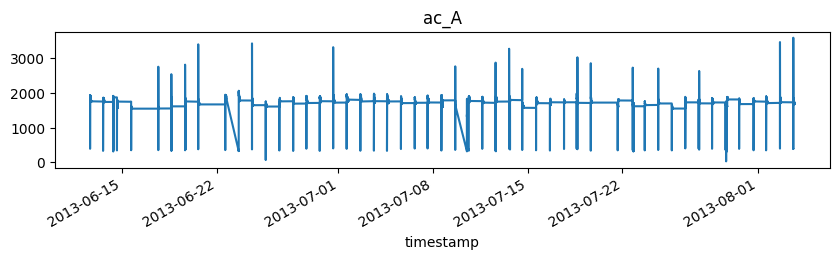

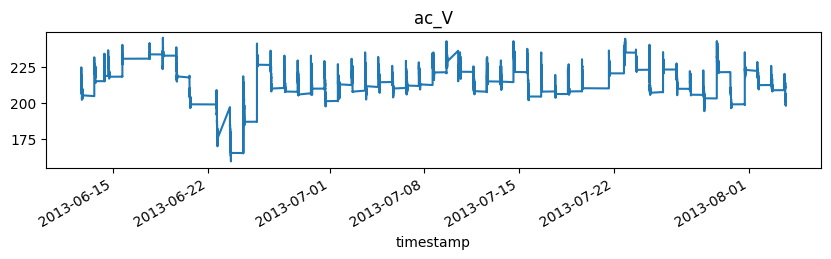

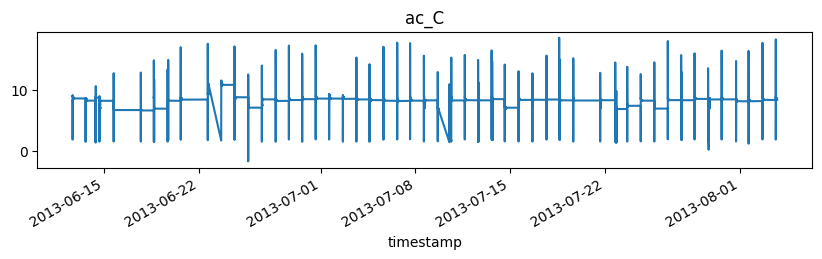

In [36]:
for i in [0,1,2]:
    df[df.columns[i]].plot()
    plt.title(df.columns[i])
    plt.show()

In [40]:
df['ac_A'].describe()

count    341412.000000
mean       1708.680100
std         269.542195
min          23.172469
25%        1689.517500
50%        1764.680000
75%        1820.650000
max        3590.700000
Name: ac_A, dtype: float64

In [41]:
df1['ac_A'].describe()

count    337732.000000
mean       1709.003410
std         268.943132
min         307.530000
25%        1689.620000
50%        1764.675000
75%        1820.652500
max        3590.700000
Name: ac_A, dtype: float64

In [20]:
df[df['ac_C']<0]

ac_A        ac_V      ac_C
timestamp                                           
2013-06-25 15:14:21  61.132031  241.196297 -1.685684

In [25]:
df.loc['2013-06-25 15:14']

ac_A        ac_V       ac_C
timestamp                                              
2013-06-25 15:14:00   342.600000  239.230000   1.560000
2013-06-25 15:14:01   342.550000  239.200000   1.560000
2013-06-25 15:14:02   342.400000  239.510000   1.559000
2013-06-25 15:14:03   343.790000  239.560000   1.565000
2013-06-25 15:14:04   344.960000  239.500000   1.569000
2013-06-25 15:14:05   345.250000  239.550000   1.570000
2013-06-25 15:14:06   345.840000  239.500000   1.573000
2013-06-25 15:14:07   345.990000  239.600000   1.573000
2013-06-25 15:14:08   345.210000  239.520000   1.570000
2013-06-25 15:14:09   344.240000  239.460000   1.566000
2013-06-25 15:14:10   343.920000  239.650000   1.565000
2013-06-25 15:14:11   343.690000  239.640000   1.564000
2013-06-25 15:14:12   343.950000  239.560000   1.564000
2013-06-25 15:14:13   342.740000  239.440000   1.561000
2013-06-25 15:14:14   342.770000  239.460000   1.561000
2013-06-25 15:14:15   344.810000  239.550000   1.568000
2013-06-25 15:14:16   345.080000  239.580000   1.569000
2013-06-25 15:14:17   344.030000  239.620000   1.564000
2013-06-25 15:14:18   342.780000  239.620000   1.560000
2013-06-25 15:14:19   343.260000  239.800000   1.561000
2013-06-25 15:14:20   343.520000  239.720000   1.561000
2013-06-25 15:14:21    61.132031  241.196297  -1.685684
2013-06-25 15:14:22   343.810000  239.880000   1.563000
2013-06-25 15:14:23  1401.330000  234.690000  12.597000
2013-06-25 15:14:24  1088.620000  236.850000   4.624000
2013-06-25 15:14:25  1219.640000  236.200000   5.200000
2013-06-25 15:14:26  1341.460000  235.630000   5.739000
2013-06-25 15:14:27  1404.890000  235.370000   6.017000
2013-06-25 15:14:28  1432.070000  235.040000   6.142000
2013-06-25 15:14:29  1451.270000  234.800000   6.237000
2013-06-25 15:14:30  1495.240000  234.690000   6.429000
2013-06-25 15:14:31  1481.740000  234.740000   6.376000
2013-06-25 15:14:32  1463.150000  234.890000   6.292000
2013-06-25 15:14:33  1468.020000  234.740000   6.317000
2013-06-25 15:14:34  1461.690000  234.730000   6.290000
2013-06-25 15:14:35  1445.260000  234.590000   6.223000
2013-06-25 15:14:36  1433.360000  234.620000   6.171000
2013-06-25 15:14:37  1437.250000  234.420000   6.193000
2013-06-25 15:14:38  1437.260000  234.460000   6.192000
2013-06-25 15:14:39  1437.030000  234.460000   6.191000
2013-06-25 15:14:40  1436.400000  234.510000   6.187000
2013-06-25 15:14:41  1435.610000  234.570000   6.182000
2013-06-25 15:14:42  1433.950000  234.450000   6.178000
2013-06-25 15:14:43  1433.650000  234.630000   6.172000
2013-06-25 15:14:44  1432.750000  234.710000   6.166000
2013-06-25 15:14:45  1433.250000  234.640000   6.170000
2013-06-25 15:14:46  1436.870000  234.510000   6.189000
2013-06-25 15:14:47  1438.180000  234.610000   6.192000
2013-06-25 15:14:48  1437.540000  234.630000   6.195000
2013-06-25 15:14:49  1439.340000  234.620000   6.203000
2013-06-25 15:14:50  1444.020000  234.540000   6.219000
2013-06-25 15:14:51  1447.840000  234.520000   6.236000
2013-06-25 15:14:52  1452.160000  234.480000   6.262000
2013-06-25 15:14:53  1456.140000  234.560000   6.277000
2013-06-25 15:14:54  1457.670000  234.010000   6.292000
2013-06-25 15:14:55  1460.950000  233.980000   6.307000
2013-06-25 15:14:56  1466.200000  233.930000   6.331000
2013-06-25 15:14:57  1491.400000  233.850000   6.442000
2013-06-25 15:14:58  1500.590000  233.840000   6.482000
2013-06-25 15:14:59  1509.290000  234.220000   6.509000

In [24]:
sliderPlot(df1['ac_C'].loc['2013-06-25'],t="line")
sliderPlot(df['ac_C'].loc['2013-06-25'],t="line")

In [28]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
df = df1.copy()
for column in df.columns:
    # Replace missing values with NaNs in the current column
    missing_indices = df[column].index[df[column].isna()]
    non_missing_indices = df[column].index[df[column].notna()]
    # Convert timestamps to numerical values
    non_missing_indices_numeric = non_missing_indices.to_numpy()
    missing_indices_numeric = missing_indices.to_numpy()
    # Create a cubic spline interpolation function for the current column
    cs = CubicSpline(non_missing_indices_numeric, df[column].dropna().to_numpy(), bc_type='not-a-knot')
    # Interpolate missing values in the current column
    df.loc[missing_indices, column] = cs(missing_indices_numeric)
# df


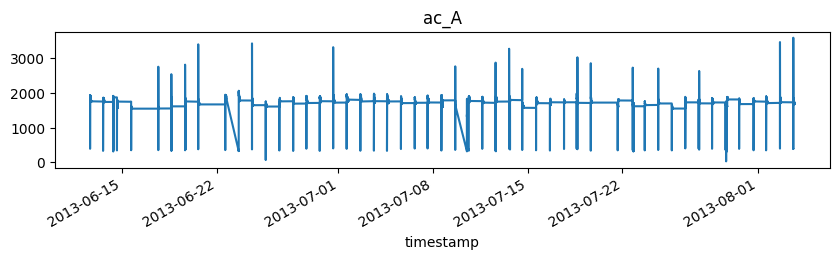

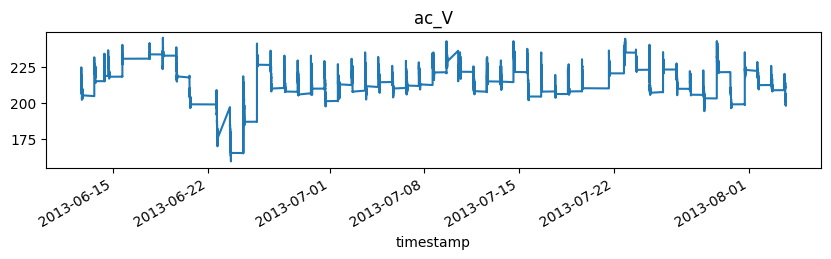

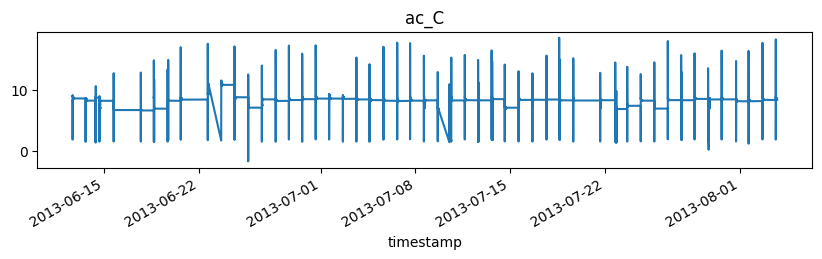

In [29]:
for i in [0,1,2]:
    df[df.columns[i]].plot()
    plt.title(df.columns[i])
    plt.show()

In [30]:
sliderPlot(df1['ac_C'].loc['2013-06-25'],t="line")
sliderPlot(df['ac_C'].loc['2013-06-25'],t="line")

In [33]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
df = df1.copy()
for column in df.columns:
    # Replace missing values with NaNs in the current column
    missing_indices = df[column].index[df[column].isna()]
    non_missing_indices = df[column].index[df[column].notna()]
    # Convert timestamps to numerical values
    non_missing_indices_numeric = non_missing_indices.to_numpy()
    missing_indices_numeric = missing_indices.to_numpy()
    # Create a cubic spline interpolation function for the current column
    cs = CubicSpline(non_missing_indices_numeric, df[column].dropna().to_numpy(), bc_type='periodic')
    # Interpolate missing values in the current column
    df.loc[missing_indices, column] = cs(missing_indices_numeric)
# df


ValueError: The first and last `y` point along axis 0 must be identical (within machine precision) when bc_type='periodic'.

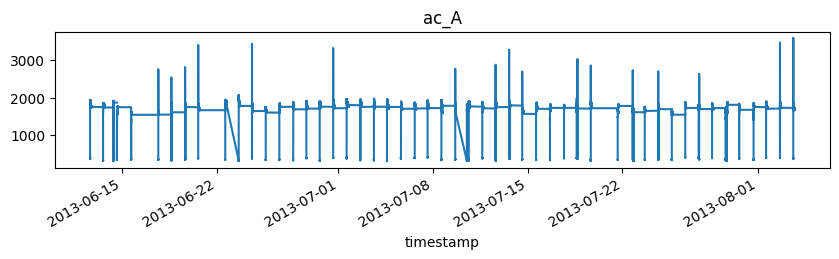

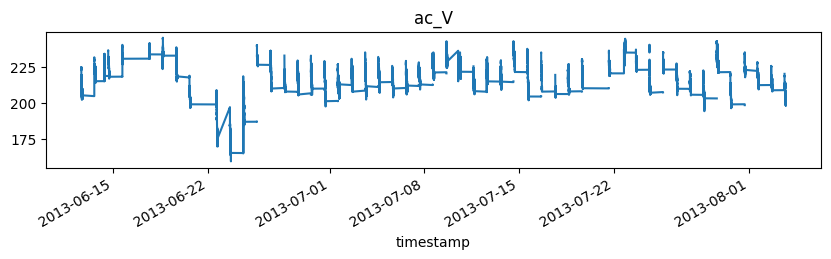

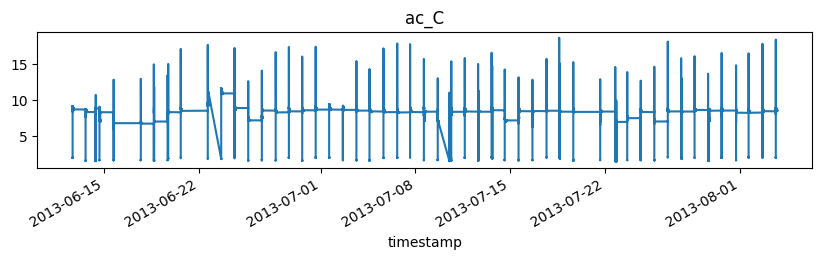

In [34]:
for i in [0,1,2]:
    df[df.columns[i]].plot()
    plt.title(df.columns[i])
    plt.show()

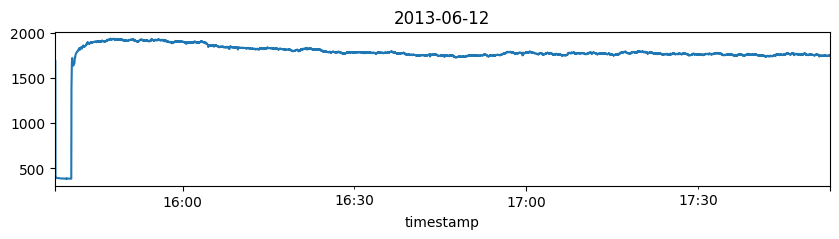

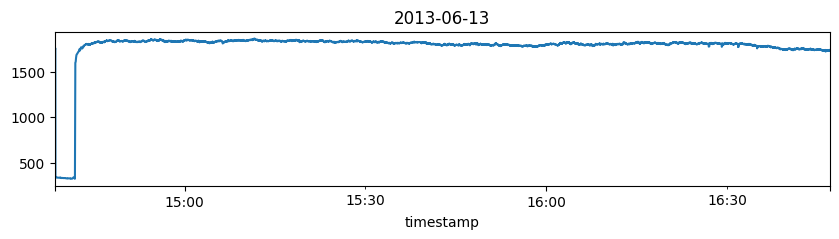

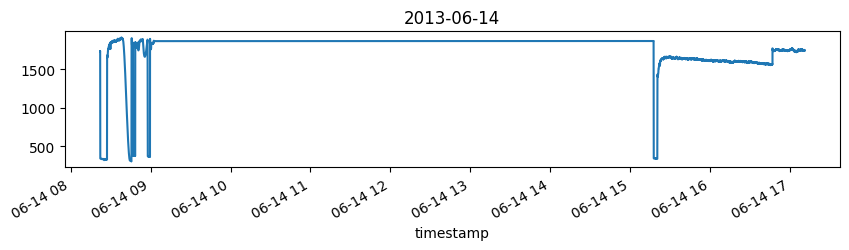

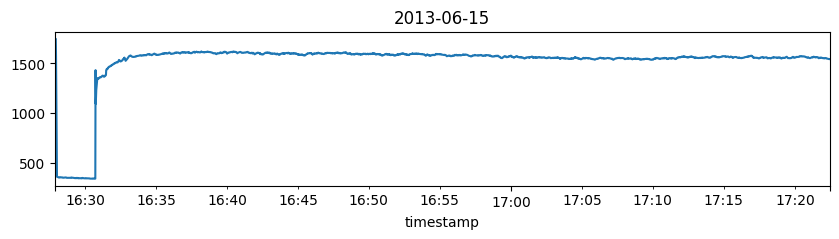

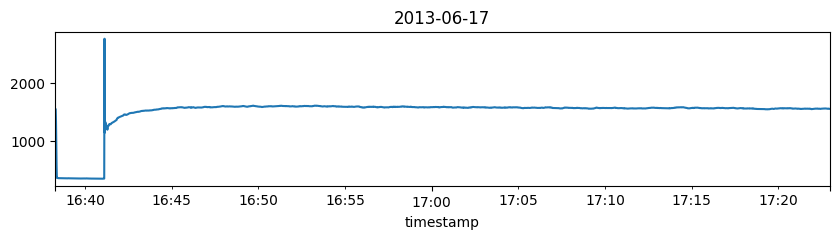

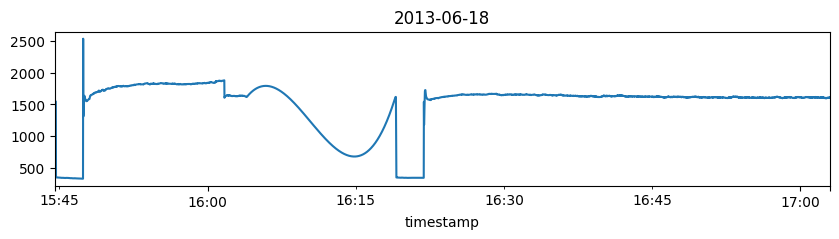

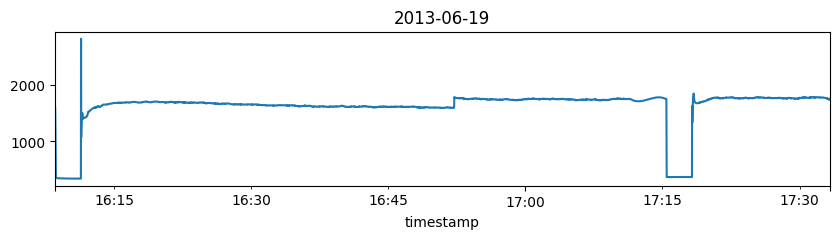

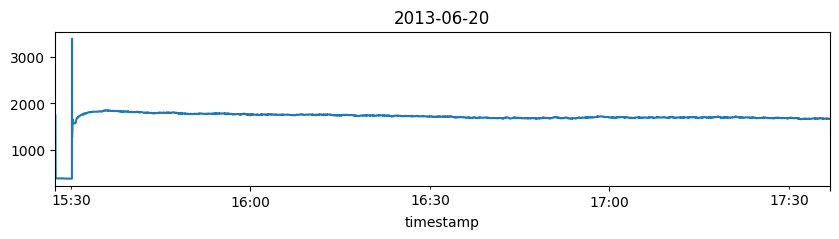

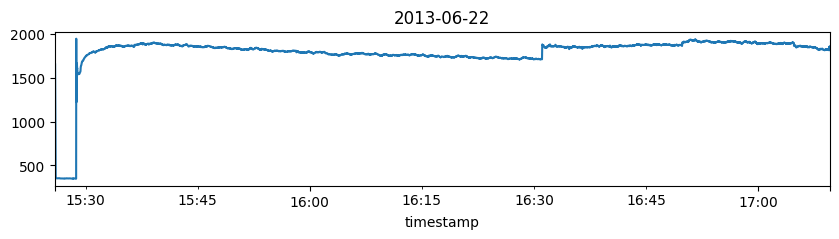

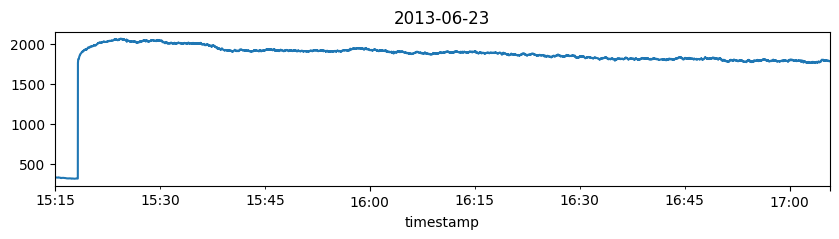

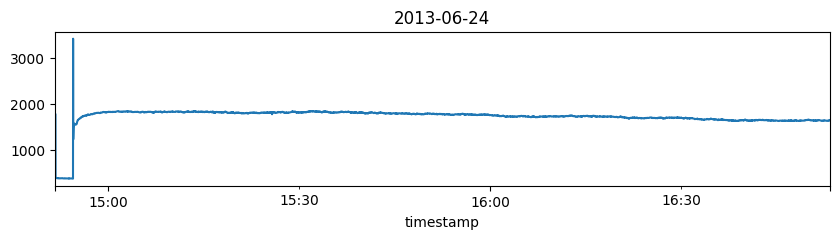

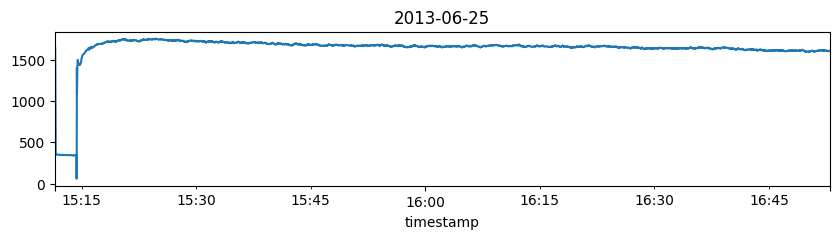

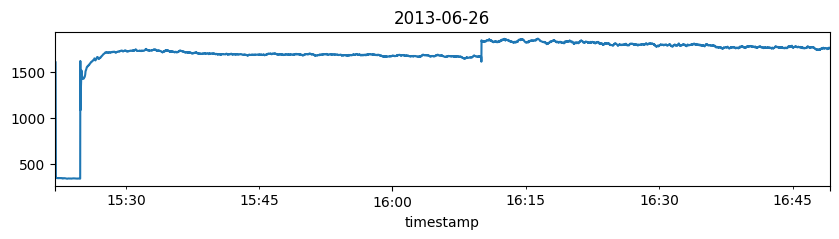

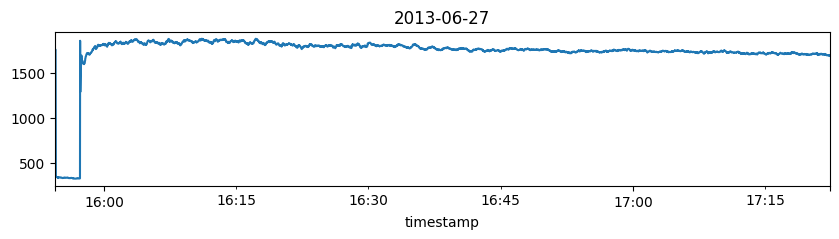

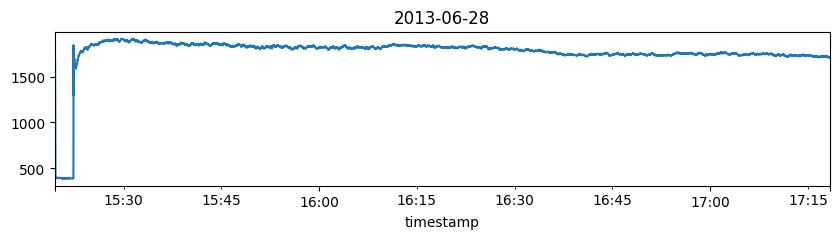

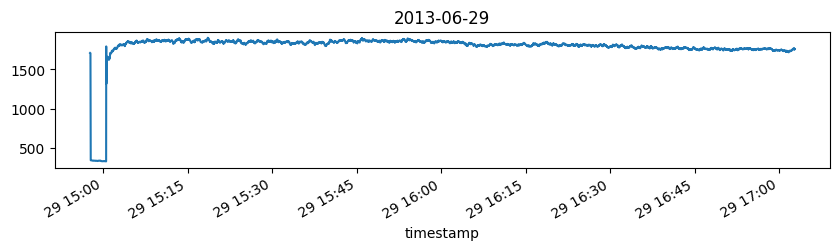

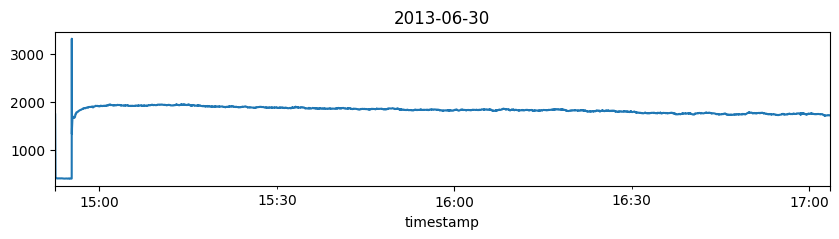

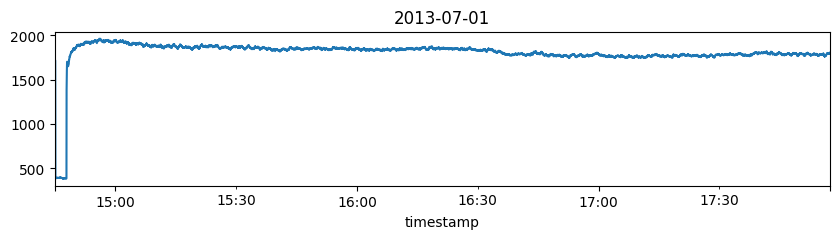

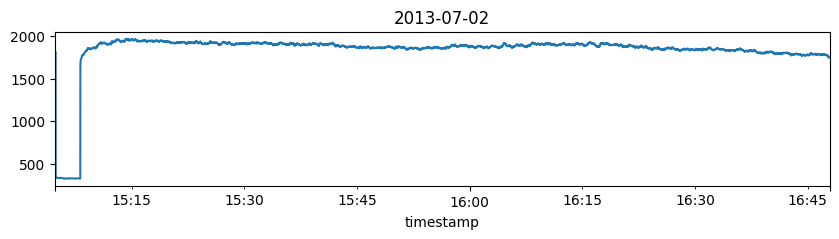

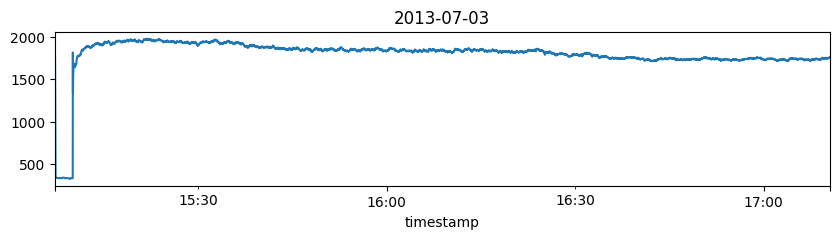

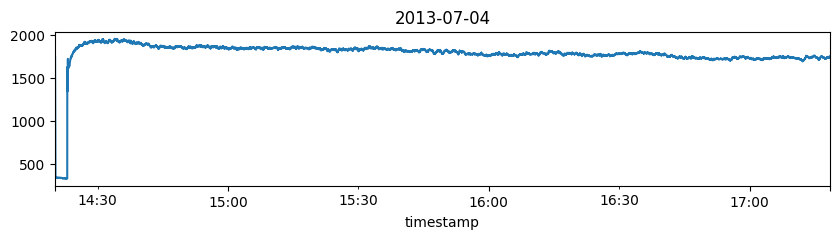

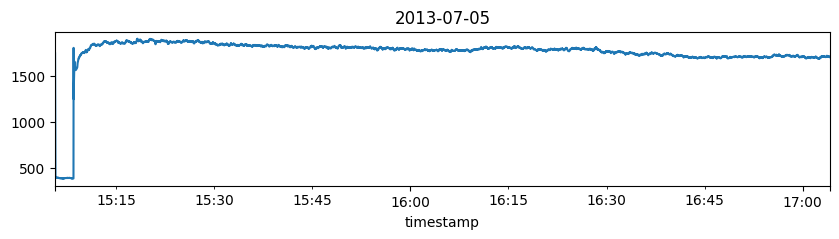

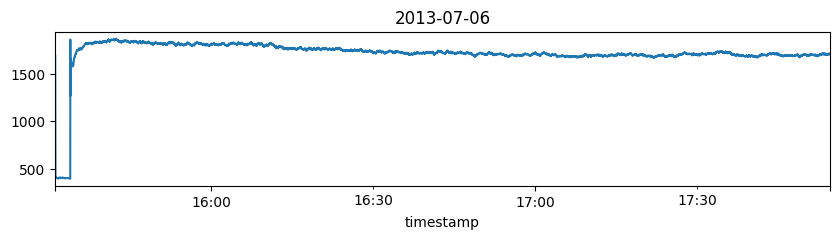

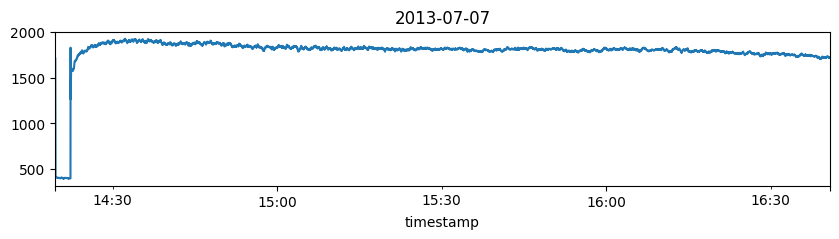

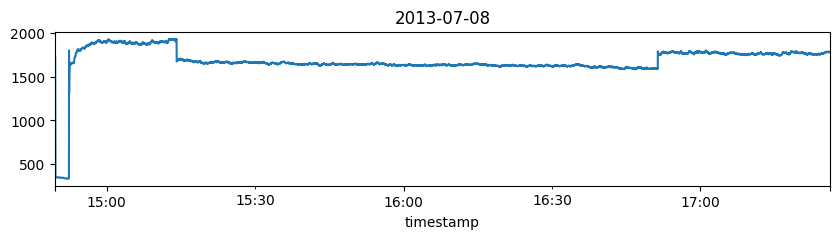

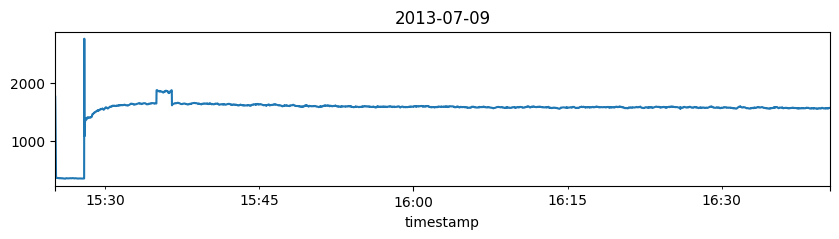

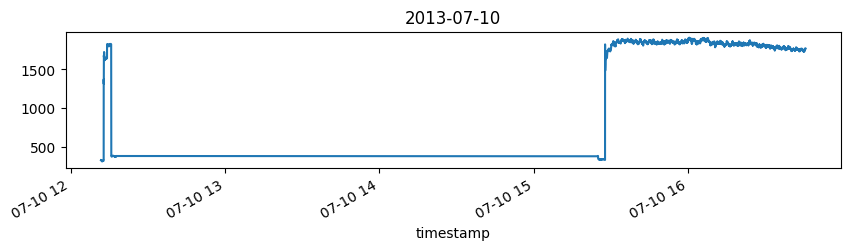

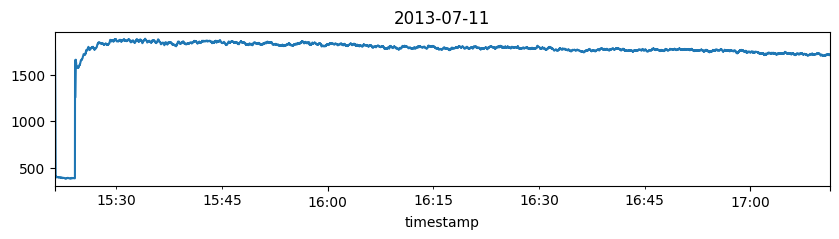

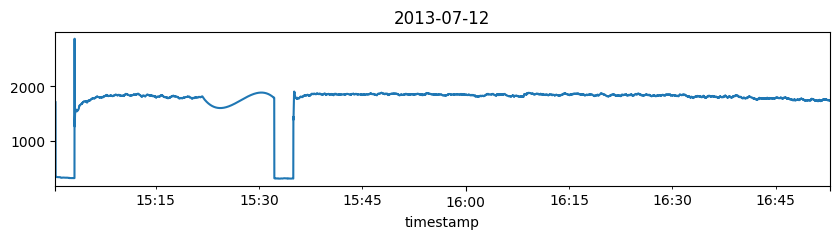

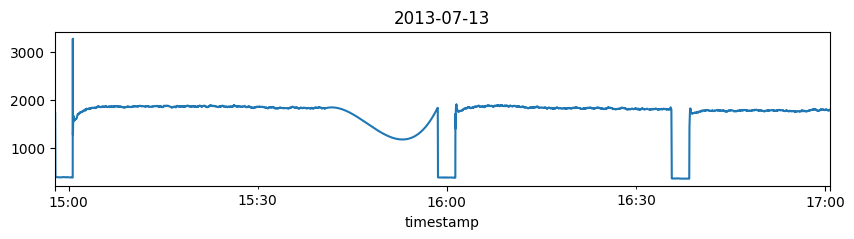

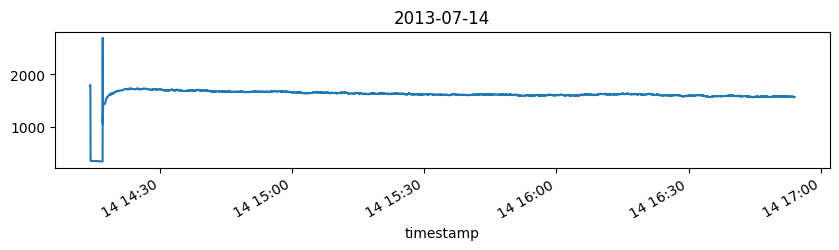

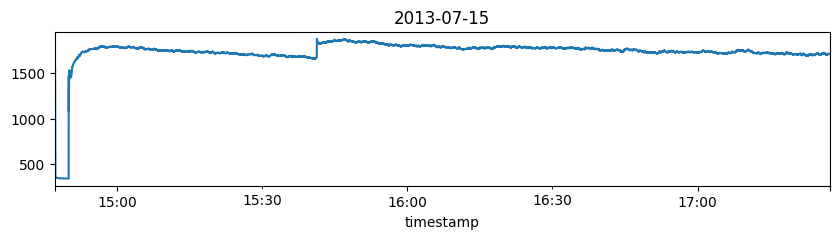

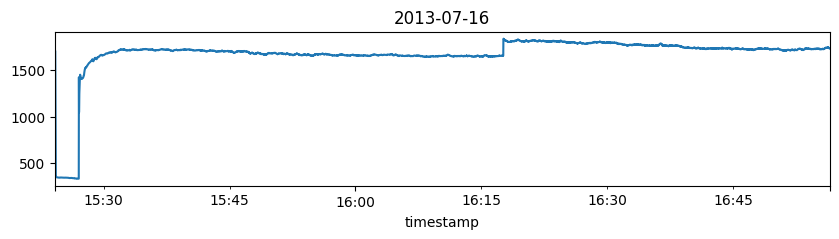

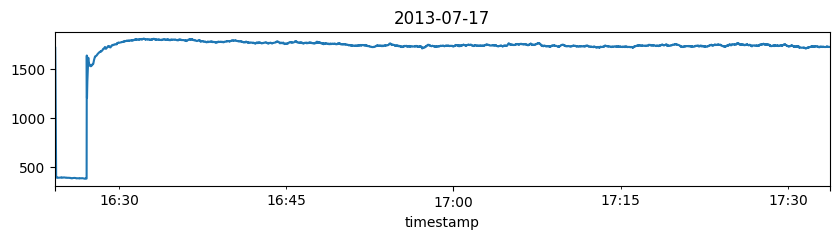

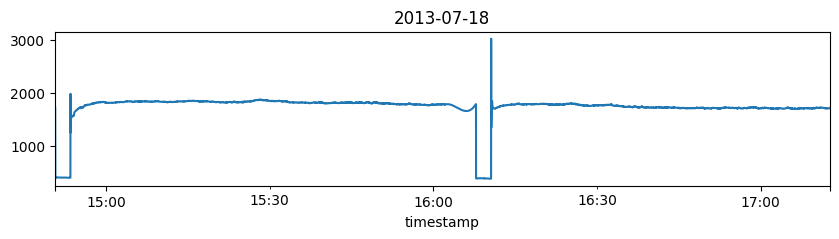

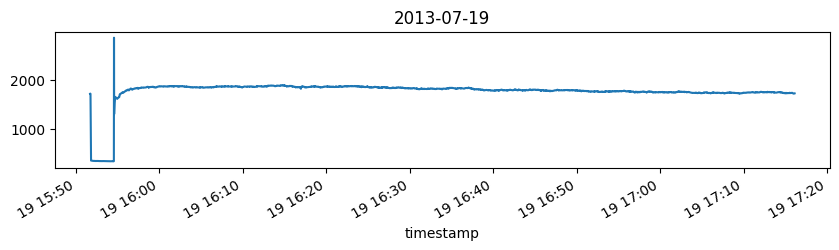

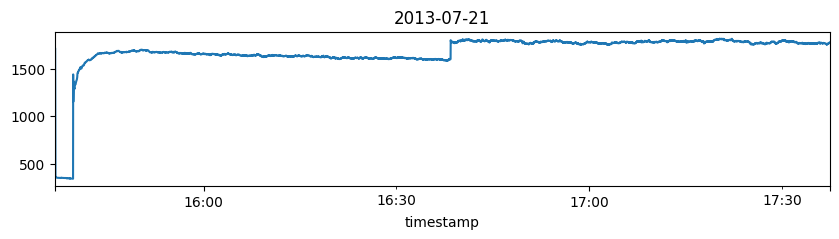

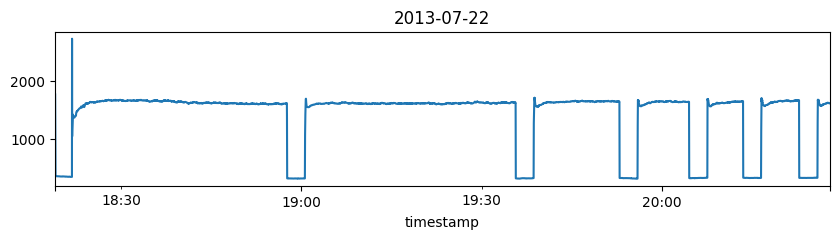

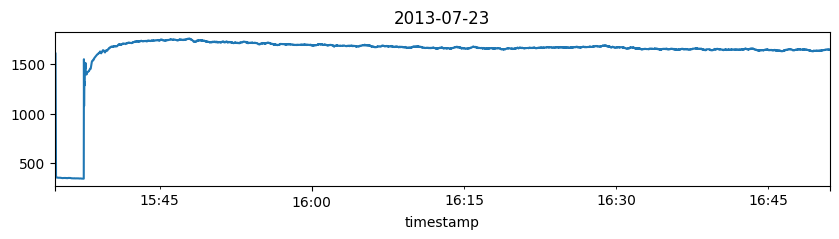

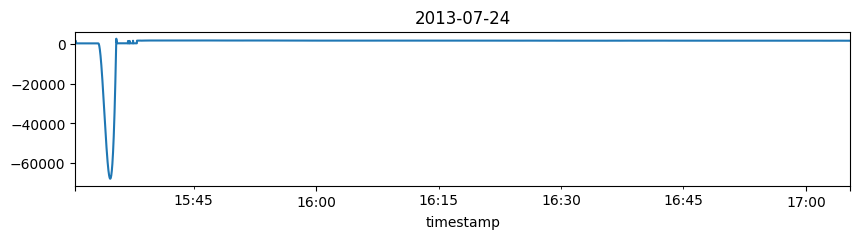

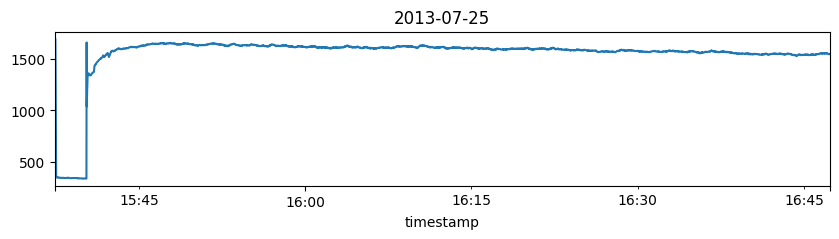

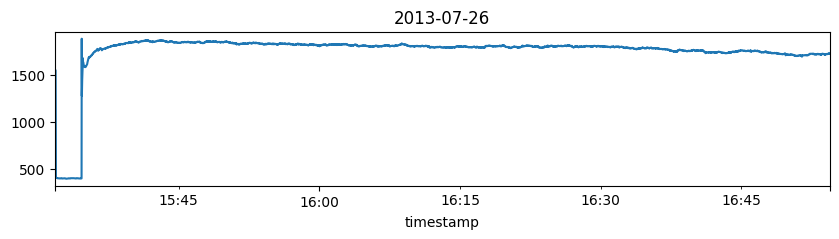

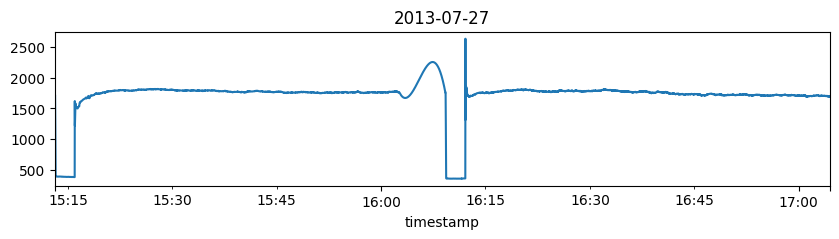

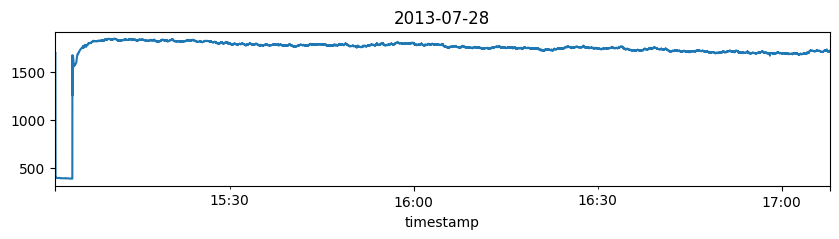

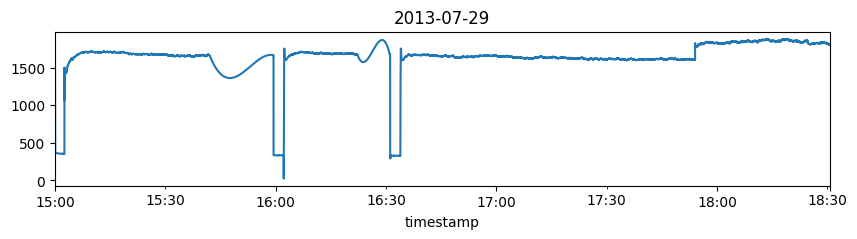

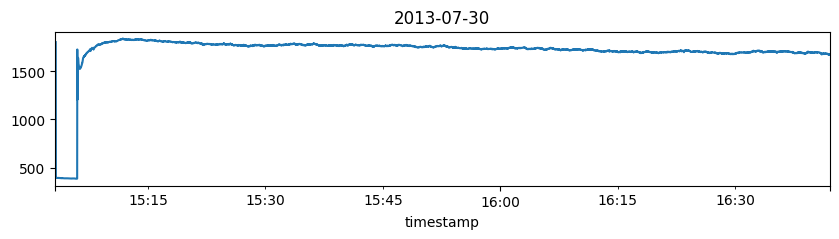

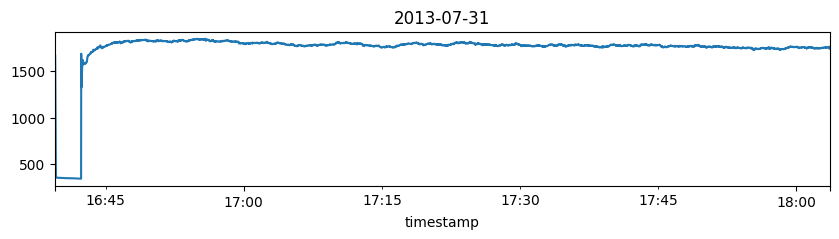

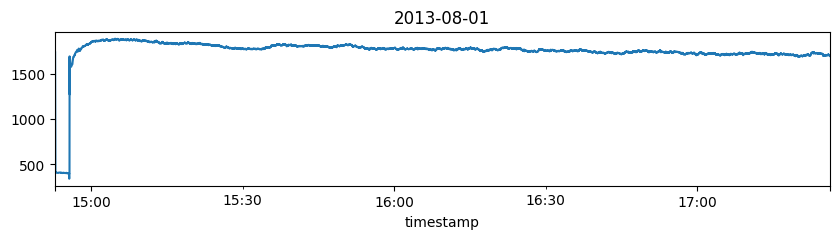

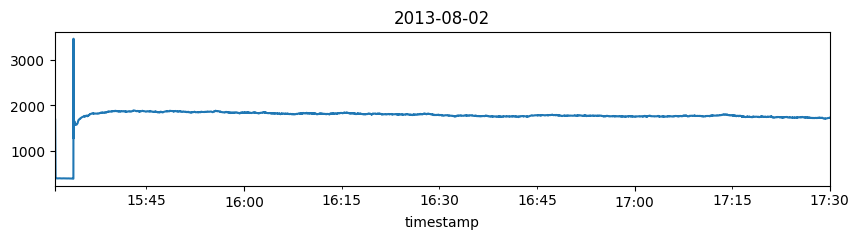

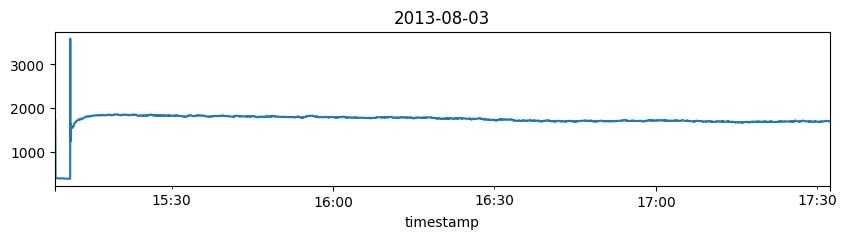

In [23]:
unique_dates = pd.Series(df.index.date).unique()
for date1 in unique_dates:
    # print(date1)
    df_date = df[df.index.to_series().dt.date == date1]
    df_date['ac1_A'].plot()
    plt.title(f"{date1}")
    plt.show()

In [34]:
# df.to_csv("d:/clean_data/c_ac.csv")
# df= pd.read_csv("d:/clean_data/c_ac.csv")
df

timestamp    ac1_A   ac1_V  ac1_C
0       2013-06-12 15:37:44  1695.42  206.51  8.318
1       2013-06-12 15:37:45  1693.94  206.49  8.320
2       2013-06-12 15:37:46  1692.68  206.57  8.319
3       2013-06-12 15:37:47  1693.01  206.50  8.315
4       2013-06-12 15:37:48  1693.09  206.56  8.313
...                     ...      ...     ...    ...
347601  2013-08-03 17:32:16  1695.33  203.78  8.429
347602  2013-08-03 17:32:17  1698.77  203.82  8.453
347603  2013-08-03 17:32:18  1697.96  203.83  8.440
347604  2013-08-03 17:32:19  1698.43  203.91  8.439
347605  2013-08-03 17:32:20  1698.07  203.65  8.448

[347606 rows x 4 columns]

In [35]:
df['timestamp'] = pd.to_datetime(df['timestamp']) 
df.set_index('timestamp', inplace=True)

<Axes: >

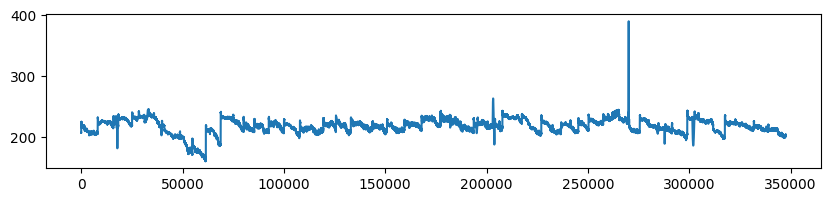

In [4]:
df['ac1_V'].plot()

In [13]:
df[df['ac1_V']>350]

timestamp         ac1_A       ac1_V       ac1_C
270092  2013-07-24 15:34:16 -47972.269484  350.391316 -228.254675
270093  2013-07-24 15:34:17 -49037.528933  352.608217 -233.320045
270094  2013-07-24 15:34:18 -50086.287067  354.785955 -238.306915
270095  2013-07-24 15:34:19 -51117.323184  356.922046 -243.209482
270096  2013-07-24 15:34:20 -52129.416581  359.014010 -248.021942
270097  2013-07-24 15:34:21 -53121.346557  361.059364 -252.738490
270098  2013-07-24 15:34:22 -54091.892410  363.055627 -257.353323
270099  2013-07-24 15:34:23 -55039.833438  365.000316 -261.860636
270100  2013-07-24 15:34:24 -55963.948940  366.890950 -266.254626
270101  2013-07-24 15:34:25 -56863.018212  368.725047 -270.529488
270102  2013-07-24 15:34:26 -57735.820553  370.500125 -274.679417
270103  2013-07-24 15:34:27 -58581.135262  372.213702 -278.698611
270104  2013-07-24 15:34:28 -59397.741636  373.863296 -282.581264
270105  2013-07-24 15:34:29 -60184.418974  375.446426 -286.321574
270106  2013-07-24 15:34:30 -60939.946573  376.960609 -289.913734
270107  2013-07-24 15:34:31 -61663.103732  378.403363 -293.351943
270108  2013-07-24 15:34:32 -62352.669748  379.772208 -296.630394
270109  2013-07-24 15:34:33 -63007.423920  381.064660 -299.743285
270110  2013-07-24 15:34:34 -63626.145545  382.278238 -302.684811
270111  2013-07-24 15:34:35 -64207.613922  383.410460 -305.449169
270112  2013-07-24 15:34:36 -64750.608350  384.458845 -308.030553
270113  2013-07-24 15:34:37 -65253.908125  385.420910 -310.423160
270114  2013-07-24 15:34:38 -65716.292546  386.294173 -312.621186
270115  2013-07-24 15:34:39 -66136.540911  387.076153 -314.618826
270116  2013-07-24 15:34:40 -66513.432518  387.764367 -316.410277
270117  2013-07-24 15:34:41 -66845.746666  388.356334 -317.989734
270118  2013-07-24 15:34:42 -67132.262651  388.849573 -319.351394
270119  2013-07-24 15:34:43 -67371.759773  389.241600 -320.489452
270120  2013-07-24 15:34:44 -67563.017330  389.529934 -321.398104
270121  2013-07-24 15:34:45 -67704.814618  389.712094 -322.071546
270122  2013-07-24 15:34:46 -67795.930938  389.785597 -322.503974
270123  2013-07-24 15:34:47 -67835.145585  389.747962 -322.689583
270124  2013-07-24 15:34:48 -67821.237860  389.596706 -322.622571
270125  2013-07-24 15:34:49 -67752.987059  389.329348 -322.297132
270126  2013-07-24 15:34:50 -67629.172481  388.943406 -321.707462
270127  2013-07-24 15:34:51 -67448.573424  388.436398 -320.847758
270128  2013-07-24 15:34:52 -67209.969186  387.805842 -319.712214
270129  2013-07-24 15:34:53 -66912.139064  387.049257 -318.295028
270130  2013-07-24 15:34:54 -66553.862358  386.164160 -316.590395
270131  2013-07-24 15:34:55 -66133.918365  385.148069 -314.592511
270132  2013-07-24 15:34:56 -65651.086382  383.998503 -312.295572
270133  2013-07-24 15:34:57 -65104.145710  382.712979 -309.693773
270134  2013-07-24 15:34:58 -64491.875644  381.289017 -306.781311
270135  2013-07-24 15:34:59 -63813.055484  379.724133 -303.552382
270136  2013-07-24 15:35:00 -63066.464527  378.015847 -300.001181
270137  2013-07-24 15:35:01 -62250.882072  376.161676 -296.121904
270138  2013-07-24 15:35:02 -61365.087416  374.159138 -291.908747
270139  2013-07-24 15:35:03 -60407.859857  372.005752 -287.355906
270140  2013-07-24 15:35:04 -59377.978695  369.699035 -282.457578
270141  2013-07-24 15:35:05 -58274.223226  367.236506 -277.207957
270142  2013-07-24 15:35:06 -57095.372749  364.615683 -271.601239
270143  2013-07-24 15:35:07 -55840.206562  361.834083 -265.631622
270144  2013-07-24 15:35:08 -54507.503963  358.889226 -259.293300
270145  2013-07-24 15:35:09 -53096.044250  355.778629 -252.580469
270146  2013-07-24 15:35:10 -51604.606720  352.499810 -245.487325

In [37]:

sliderPlot(df1['ac1_A'].loc['2013-07-24'],t="line")
sliderPlot(df['ac1_A'].loc['2013-07-24'],t="line")

<Axes: >

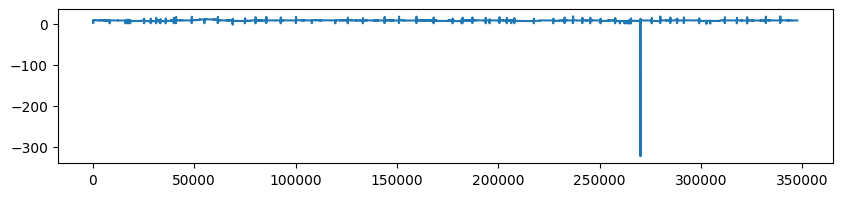

In [6]:
df['ac1_C'].plot()

<Axes: >

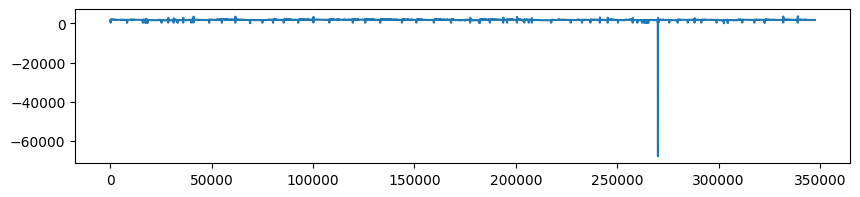

In [7]:
df['ac1_A'].plot()

In [8]:
df[df['ac1_A']<0]

timestamp         ac1_A       ac1_V      ac1_C
270040  2013-07-24 15:33:24   -118.256424  242.705020  -0.648817
270041  2013-07-24 15:33:25   -359.457003  243.538418  -1.798078
270042  2013-07-24 15:33:26   -647.632768  244.461711  -3.170654
270043  2013-07-24 15:33:27   -981.563015  245.472415  -4.760740
270044  2013-07-24 15:33:28  -1360.027044  246.568049  -6.562532
...                     ...           ...         ...        ...
270162  2013-07-24 15:35:26 -15868.530508  275.135348 -75.538349
270163  2013-07-24 15:35:27 -12830.702712  268.617033 -61.091860
270164  2013-07-24 15:35:28  -9690.924465  261.885823 -46.160586
270165  2013-07-24 15:35:29  -6447.975065  254.939235 -30.738720
270166  2013-07-24 15:35:30  -3100.633811  247.774788 -14.820459

[127 rows x 4 columns]

In [10]:
lst = ['ac1']
path = "d:/NILM/Data_files/Parquet/Appliances12_06_04_08/"
print("data read done")
""" data ingestion done """

""" data transformation """
complete_data_lst = [] # empty list to store final data set of all appliances
for i in range(len(lst)):
    df = pd.read_parquet(f"{path}{lst[i]}.parquet")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.drop_duplicates(inplace=True)  
    df.set_index(['timestamp'],inplace=True ,drop=True)
    df.drop(df[(df['frequency']>51) | (df['frequency']<49)].index, inplace=True)
    df.drop(df[(df['PF']>1) | (df['PF']<0)].index, inplace=True)
    # df.drop(df[(df['current']>20) |(df['current']<0.07)].index, inplace=True)
    df.drop(df[df['voltage']<140].index, inplace=True)
    
    # power is active power derived from voltage current and pf
    df['power'] = (df['voltage'] * df['current'] * df['PF']).round(2)
    
    if lst[i]=="f":
        df_appliance = df[['power',"voltage",'current']].resample(rule="1s").asfreq()
        df_appliance = df_appliance.rename(columns={'power': f'{lst[i]}_A', 'voltage': f'{lst[i]}_V', 'current': f'{lst[i]}_C'})
    else:
        df_sample_lst = [] # empty list for storing resampled data at 1sec frequency of each hour
        unique_dates = pd.Series(df.index.date).unique()
        for date1 in unique_dates: # dates when applince is on                             
            df_date = df[df.index.to_series().dt.date == date1] # dataframe of that perticular date
            hours = df_date.index.hour.unique() # hours when appliance is on
            for h in hours:
                date2 = f"{date1} {h:02d}"
                df_hour = df_date.loc[date2] # dataframe of that perticular hour at which appliance was on
                mins = df_hour.index.minute.unique()
                for m in mins:
                    date3 = f"{date2}{m:02d}"
                    df_min = df_hour.loc[date3]
                    df_resampled_min = df_min[['power',"voltage",'current']].resample(rule="1s").asfreq()
                    df_sample_lst.append(df_resampled_min) # adding each hour data in lst
        df_appliance = pd.concat(df_sample_lst) # concating all hours data into single data frame with missing values within signature
        df_appliance = df_appliance.rename(columns={'power': f'{lst[i]}_A', 'voltage': f'{lst[i]}_V', 'current': f'{lst[i]}_C'})
        # df_appliance = create_features(df_appliance)
    complete_data_lst.append(df_appliance) # all applince data in list

data read done


In [12]:
df = complete_data_lst[0]

In [13]:
print(len(df))
print(df.isna().sum())
df

341412
ac1_A    3680
ac1_V    3680
ac1_C    3680
dtype: int64


ac1_A   ac1_V  ac1_C
timestamp                                  
2013-06-12 15:37:44  1695.42  206.51  8.318
2013-06-12 15:37:45  1693.94  206.49  8.320
2013-06-12 15:37:46  1692.68  206.57  8.319
2013-06-12 15:37:47  1693.01  206.50  8.315
2013-06-12 15:37:48  1693.09  206.56  8.313
...                      ...     ...    ...
2013-08-03 17:32:16  1695.33  203.78  8.429
2013-08-03 17:32:17  1698.77  203.82  8.453
2013-08-03 17:32:18  1697.96  203.83  8.440
2013-08-03 17:32:19  1698.43  203.91  8.439
2013-08-03 17:32:20  1698.07  203.65  8.448

[341412 rows x 3 columns]

In [14]:
df=create_features(df)
original_timestamps = df.index
knn_imputer = KNNImputer(n_neighbors=1)
imputed_data = knn_imputer.fit_transform(df)

imputed_df1 = pd.DataFrame(imputed_data, columns=df.columns)
imputed_df1['Timestamp'] = original_timestamps
imputed_df1.set_index(['Timestamp'],drop=True,inplace=True)
# sliderPlot(df['ac1_A'].loc['2013-06-18'],t="line")
# sliderPlot(imputed_df['ac1_A'].loc['2013-06-18'],t="line")


In [15]:
df = imputed_df1[["ac1_A","ac1_V","ac1_C"]]

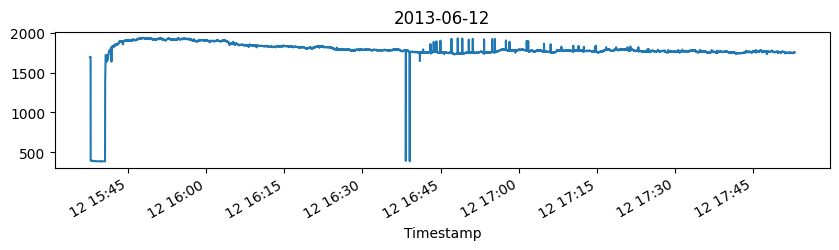

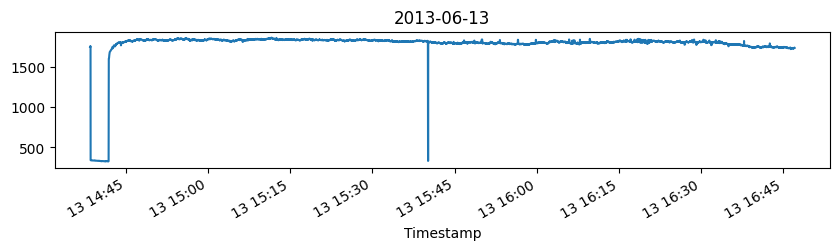

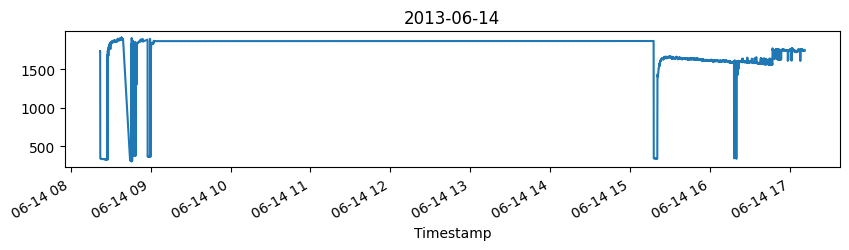

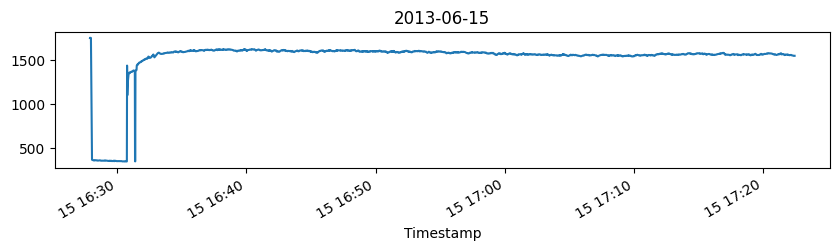

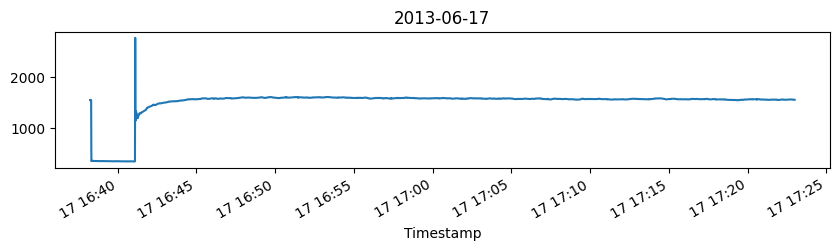

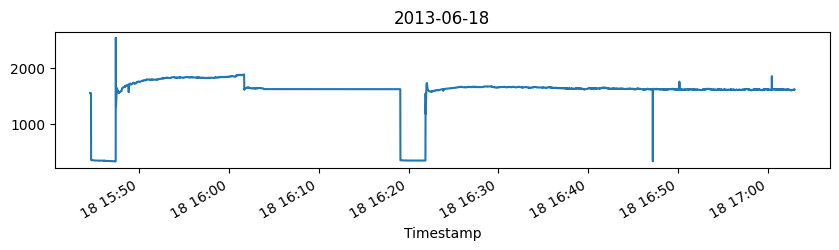

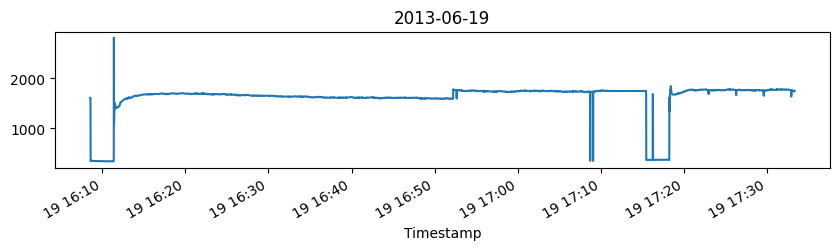

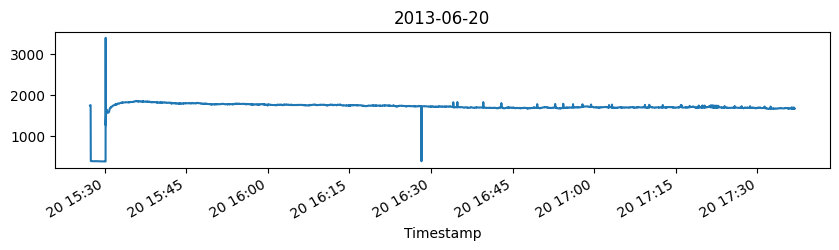

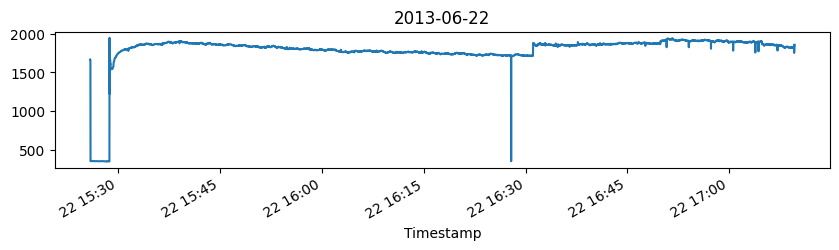

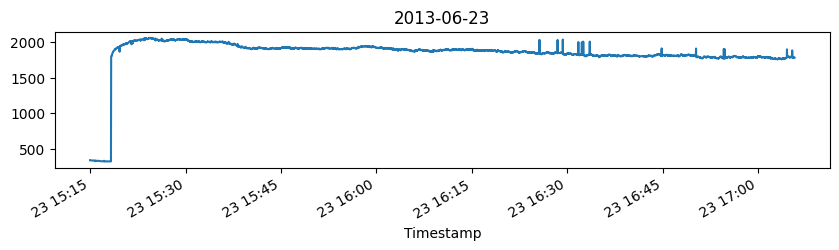

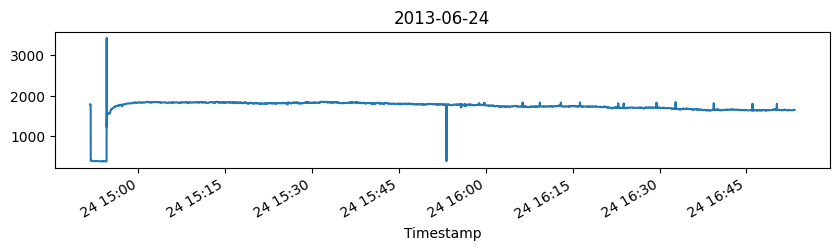

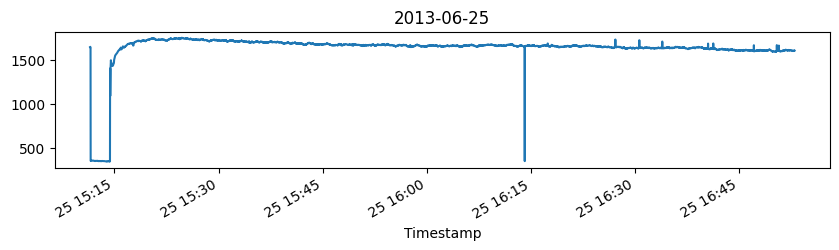

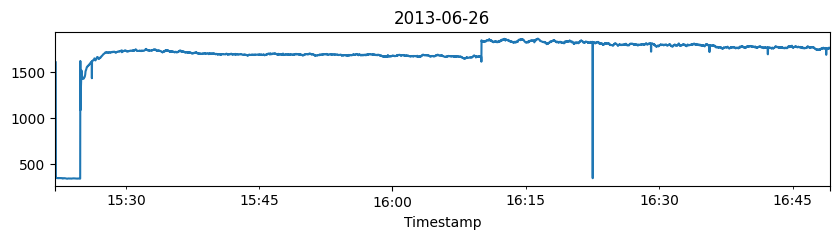

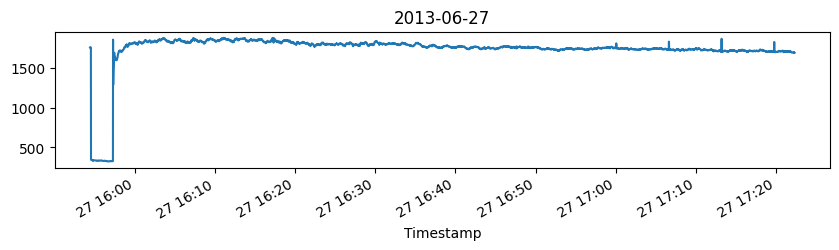

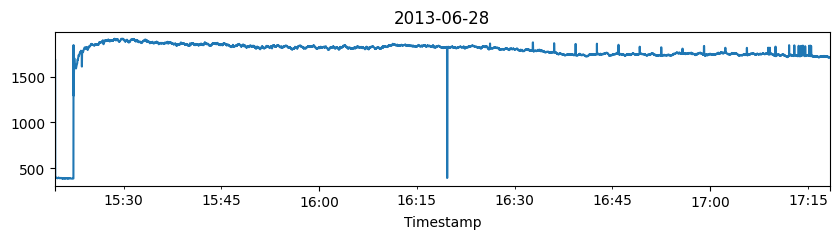

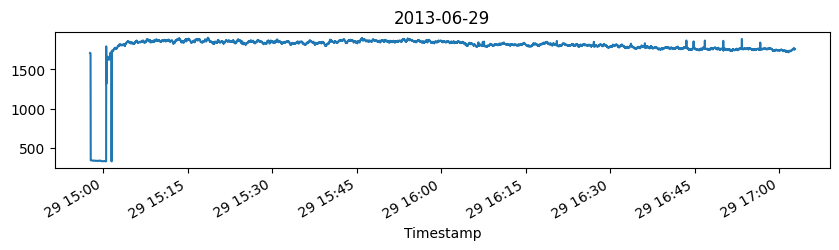

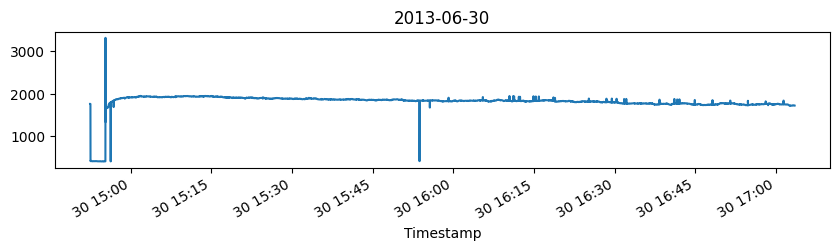

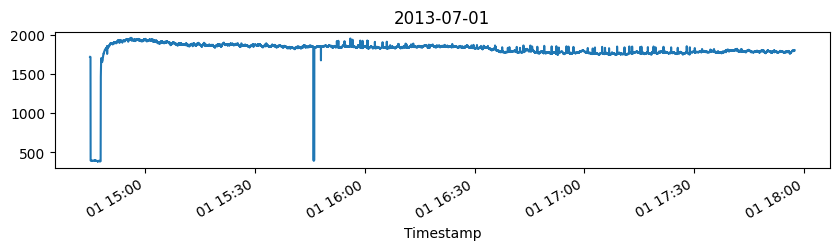

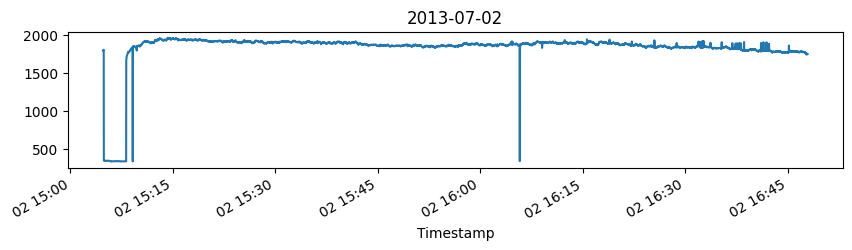

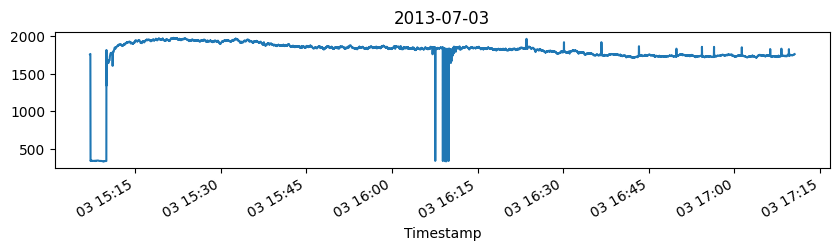

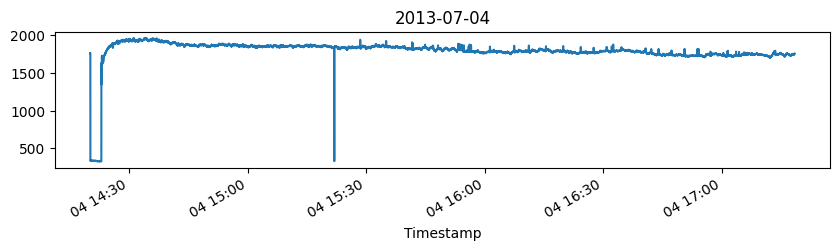

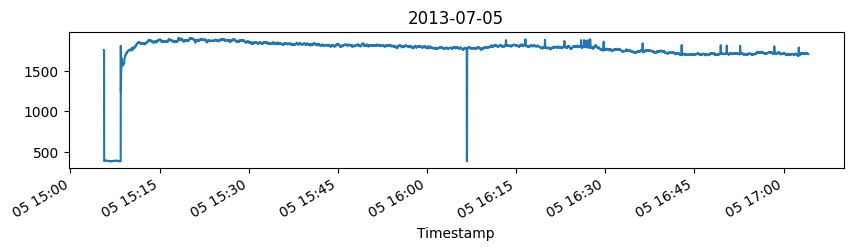

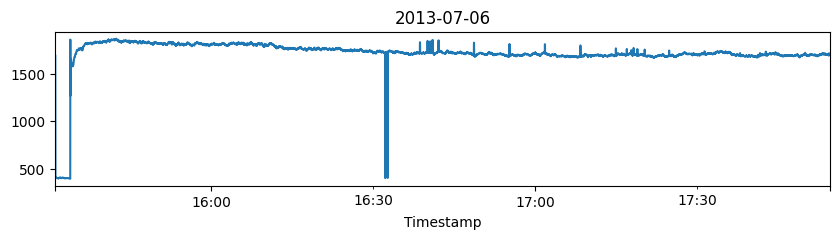

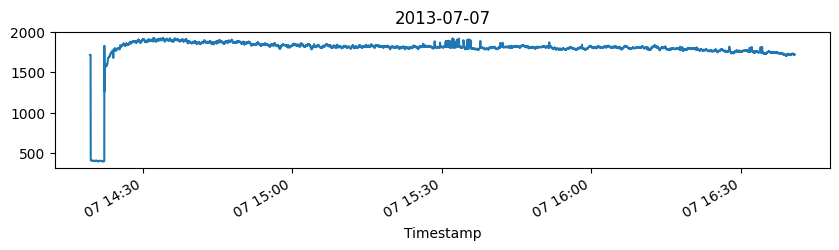

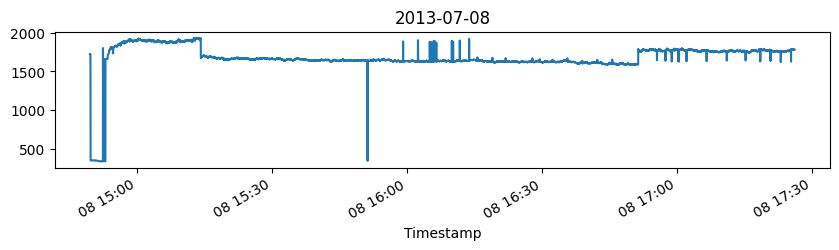

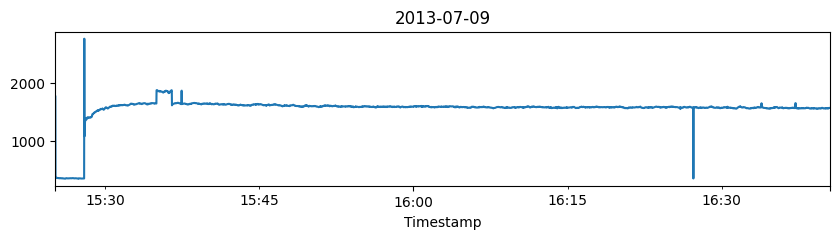

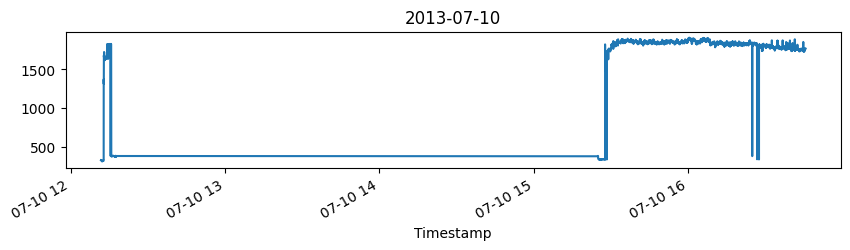

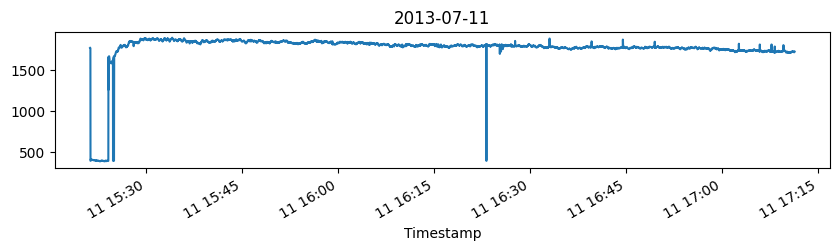

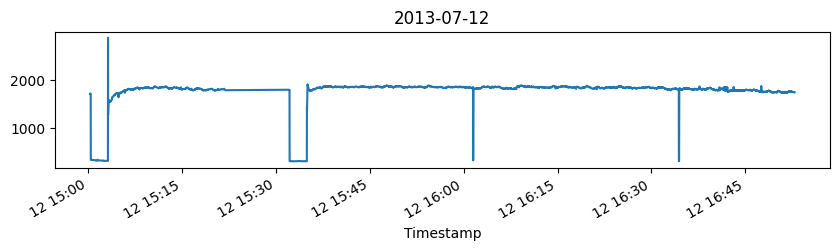

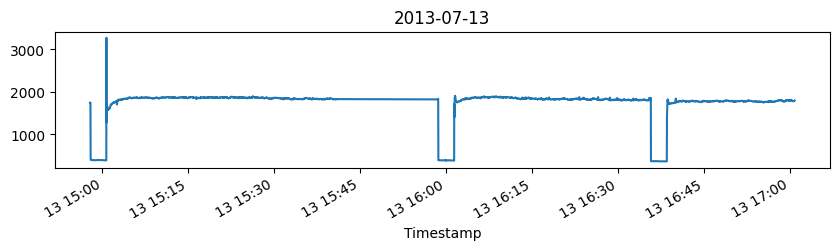

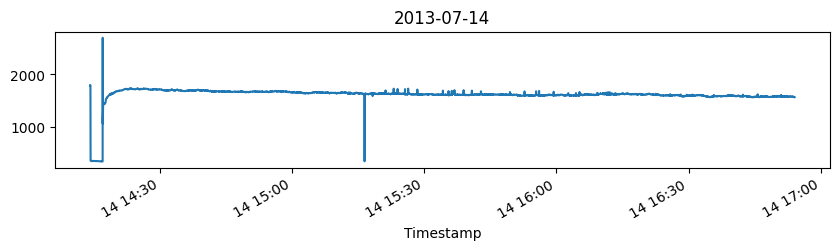

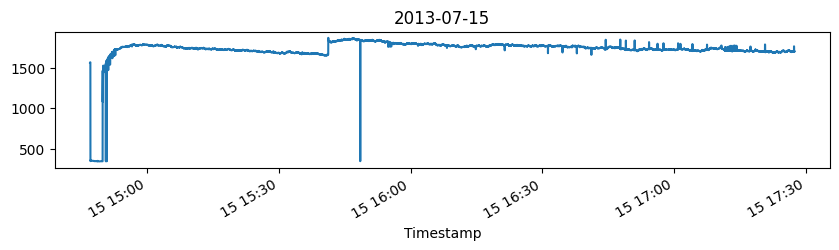

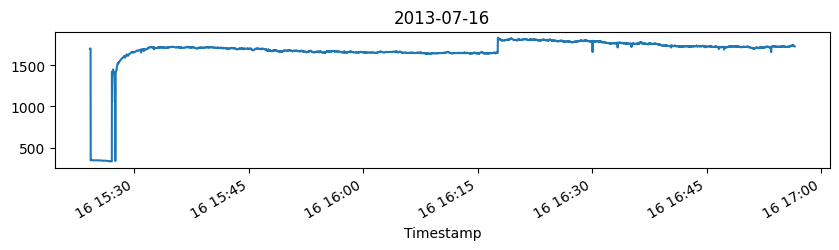

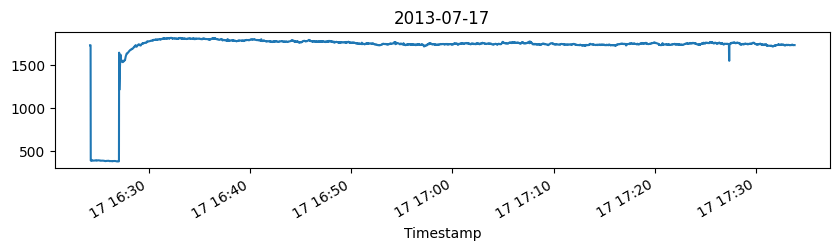

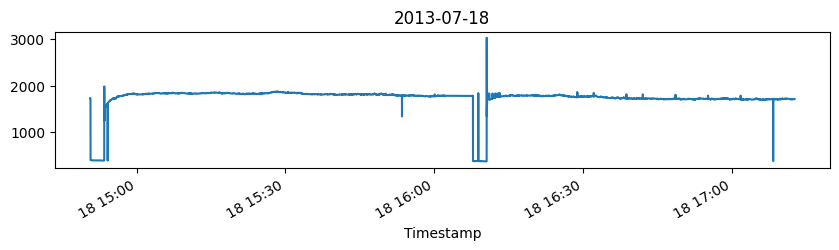

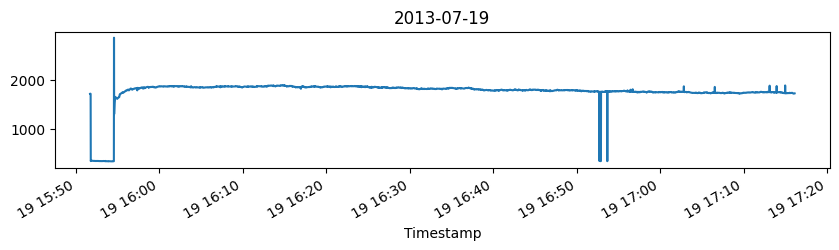

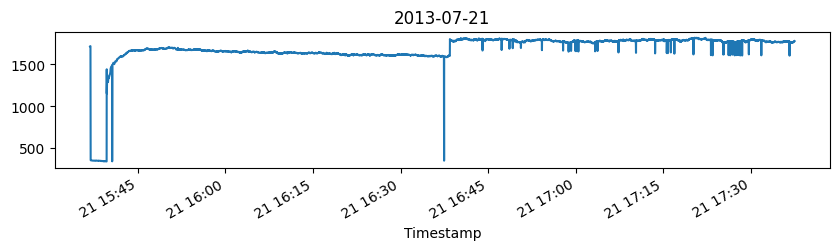

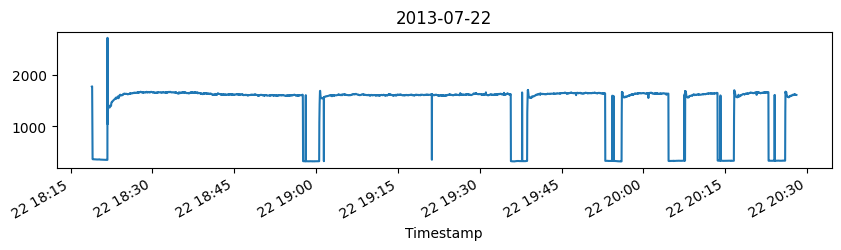

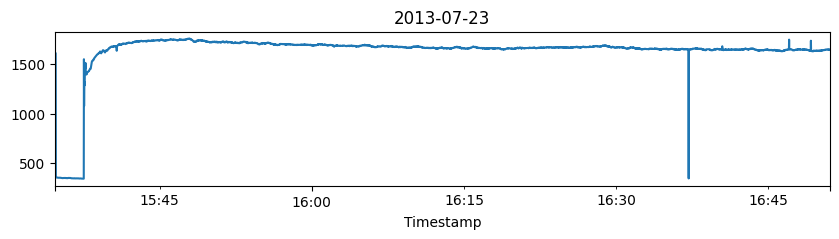

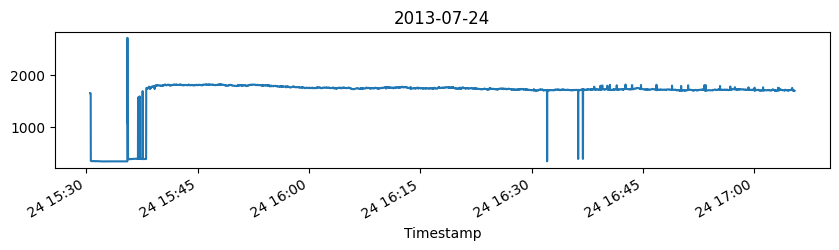

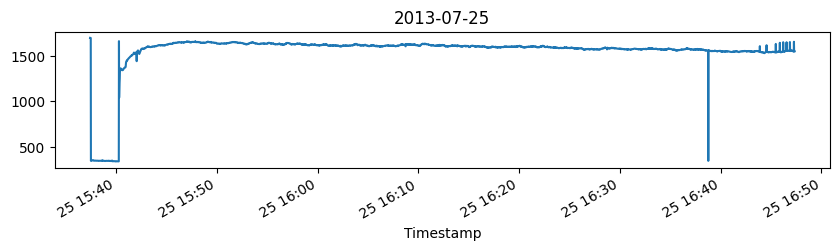

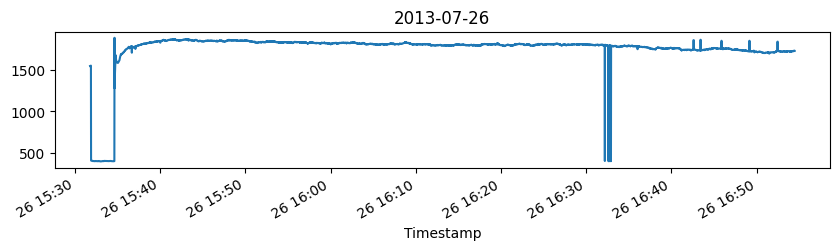

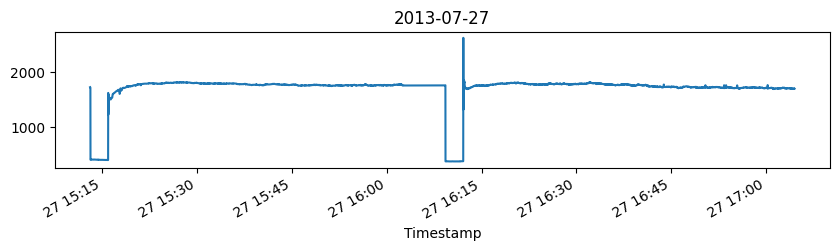

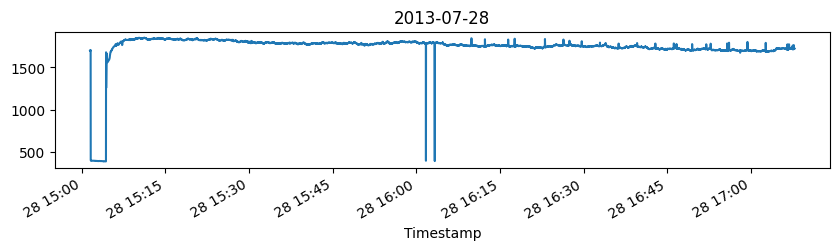

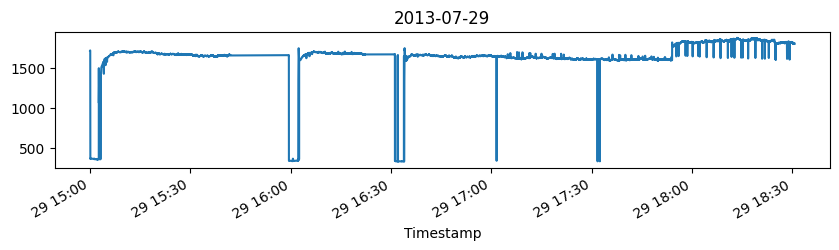

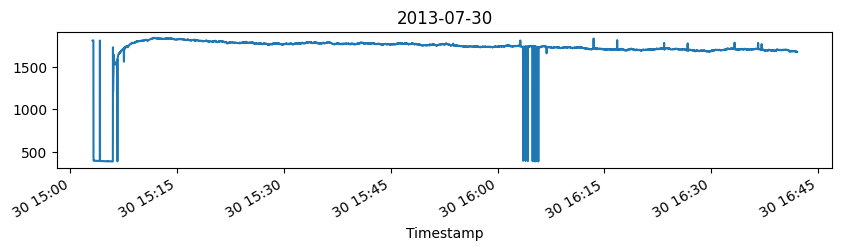

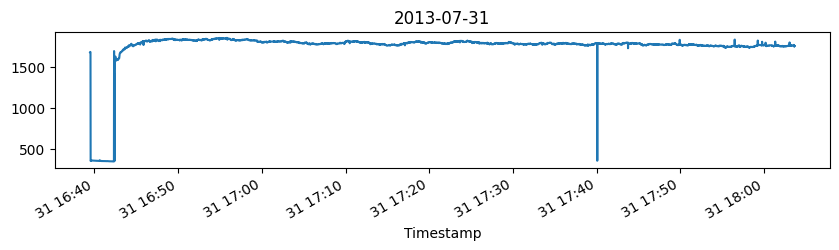

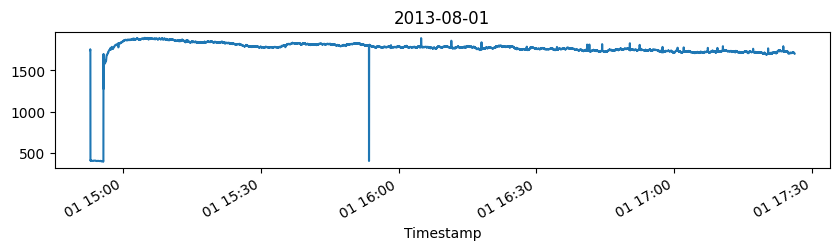

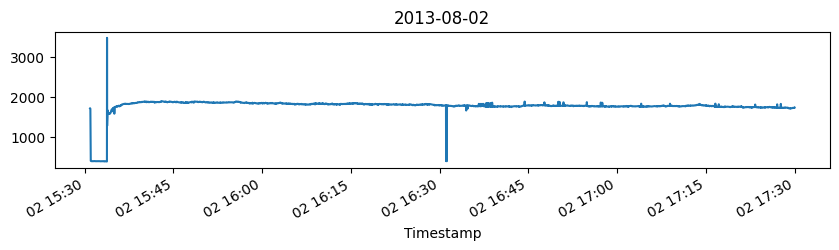

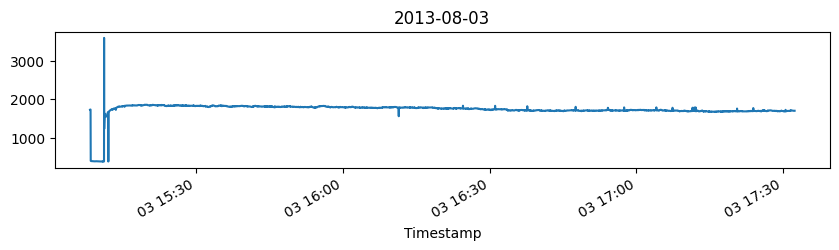

In [16]:
unique_dates = pd.Series(df.index.date).unique()
for date1 in unique_dates:
    # print(date1)
    df_date = df[df.index.to_series().dt.date == date1]
    df_date['ac1_A'].plot()
    plt.title(f"{date1}")
    plt.show()

In [8]:
df.describe()

ac1_A          ac1_V          ac1_C
count  337732.000000  337732.000000  337732.000000
mean     1709.003410     217.402746       8.101514
std       268.943132      11.666274       1.426605
min       307.530000     159.840000       1.436000
25%      1689.620000     211.210000       7.581000
50%      1764.675000     218.520000       8.498000
75%      1820.652500     225.060000       8.673000
max      3590.700000     245.230000      18.646000

<Axes: xlabel='timestamp'>

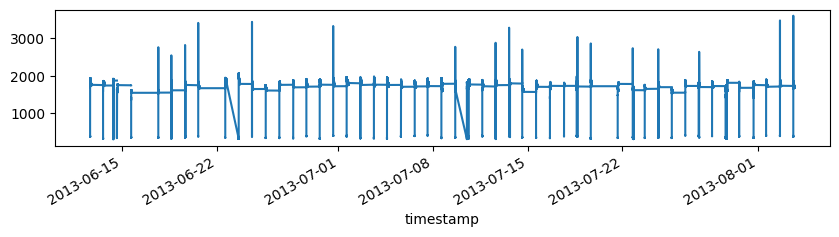

In [9]:
df['ac1_A'].plot()

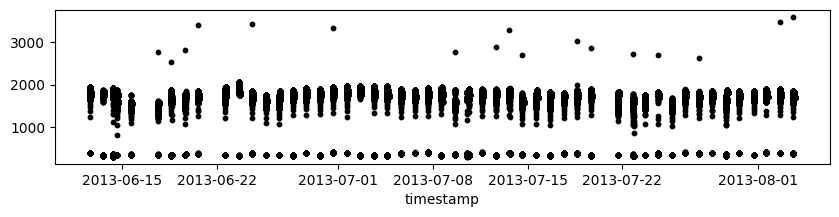

In [10]:
scatter(df['ac1_A'])

<Axes: xlabel='timestamp'>

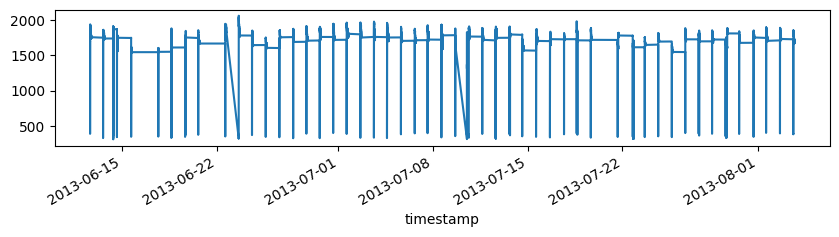

In [13]:
df1 = df[df['ac1_A']<2100]
df1['ac1_A'].plot()

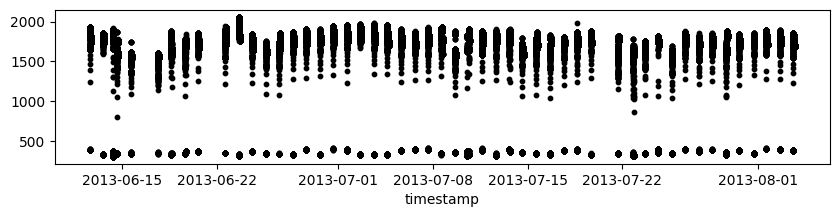

In [17]:
scatter(df1['ac1_A'])

In [18]:
df1.describe()

ac1_A          ac1_V          ac1_C
count  337715.000000  337715.000000  337715.000000
mean     1708.938890     217.402485       8.101156
std       268.785765      11.666322       1.425691
min       307.530000     159.840000       1.436000
25%      1689.610000     211.210000       7.581000
50%      1764.670000     218.520000       8.498000
75%      1820.650000     225.060000       8.673000
max      2060.420000     245.230000      18.646000

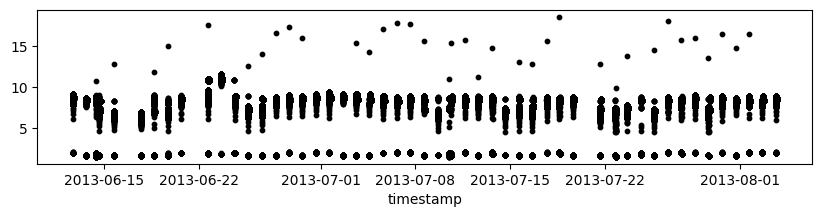

In [19]:
scatter(df1['ac1_C'])

In [20]:
sliderPlot(df1['ac1_C'].loc["2013-06-14"],t="line")

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_tv.index, df_tv['active power'], label='Original Data - Active Power')
plt.plot(df_tv['active power'].rolling(window=12).mean(), label='Rolling Mean (window=12)')
plt.plot(df_tv['active power'].rolling(window=12).std(), label='Rolling Std (window=12)')
plt.title('Original Time Series Data - Active Power with Rolling Mean and Rolling Std')
plt.xlabel('Timestamp')
plt.ylabel('Active Power')
plt.legend()
plt.show()

In [16]:
sliderPlot(df['ac1_A'].loc['2013-07-10'])